## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

## Dataset

In [2]:
df = pd.read_csv("Mall_Customers.csv", index_col="CustomerID")

In [3]:
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
Genre                     200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [5]:
quantitative = [column for column in df.columns if df[column].dtype!="object"]
qualitative = [column for column in df.columns if column not in quantitative]

In [6]:
df[quantitative].describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [7]:
df[qualitative].describe()

,Genre
count,200
unique,2
top,Female
freq,112


## Clustering reduced dataset

In [8]:
X = df.loc[:, quantitative[1:]]

In [9]:
wcss = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(X)
    wcss[k] = kmeans.inertia_

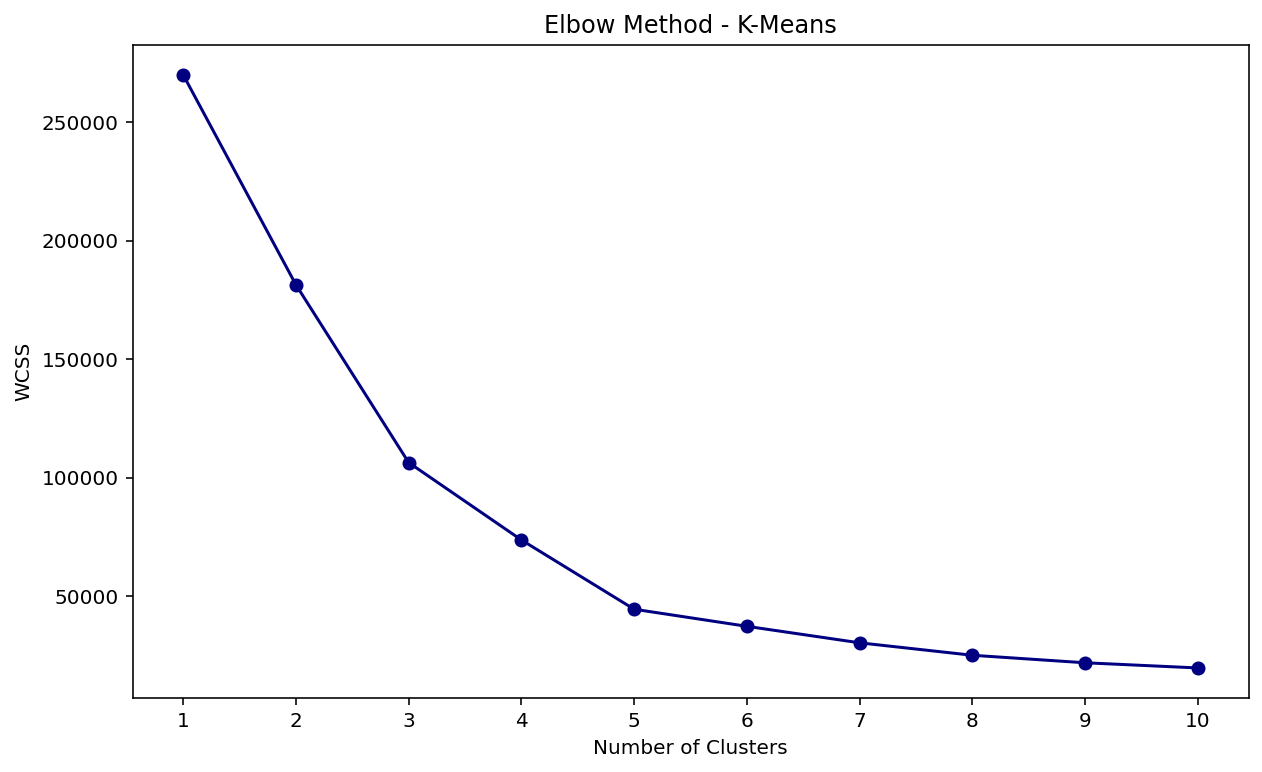

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title("Elbow Method - K-Means")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("WCSS")
ax.xaxis.set_ticks(np.arange(1, 11, 1))
ax.plot(list(wcss.keys()), list(wcss.values()), color="navy")
ax.scatter(list(wcss.keys()), list(wcss.values()), color="navy")
plt.show()

In [11]:
k_best = 5

kmeans = KMeans(n_clusters=k_best, random_state=0, n_jobs=-1)
clusters = kmeans.fit_predict(X)

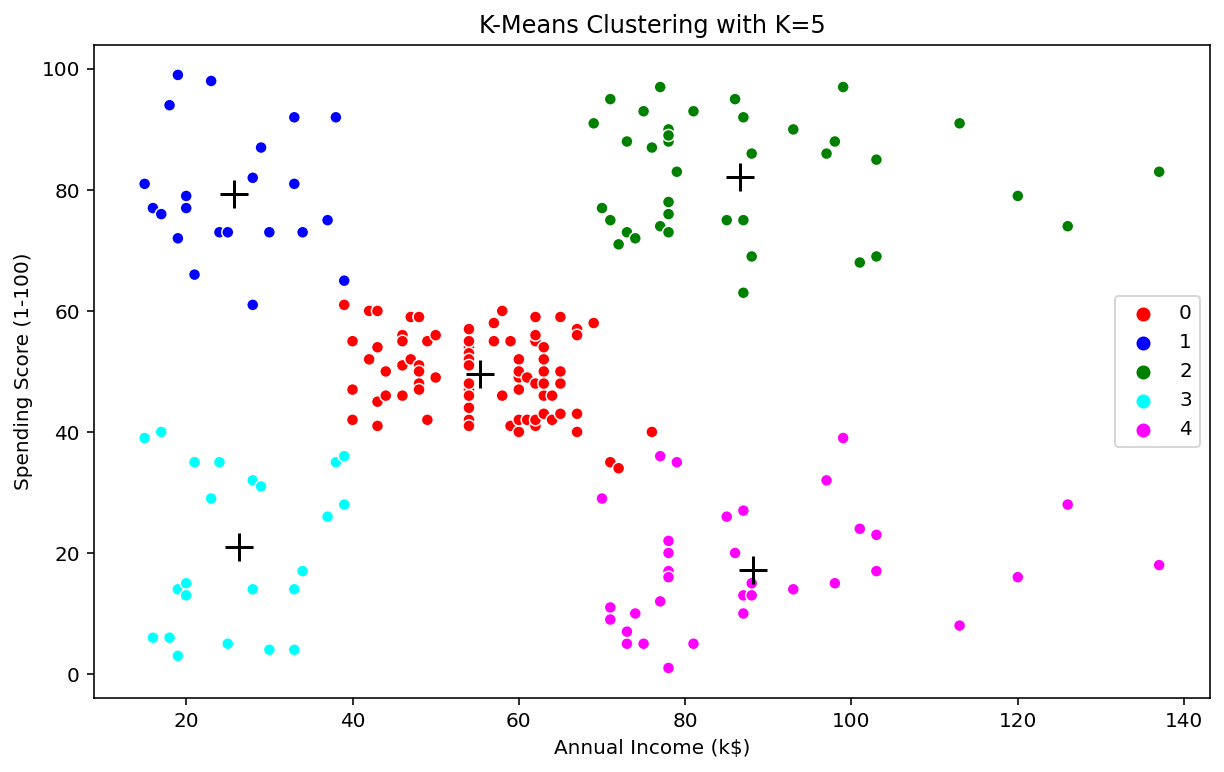

In [12]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=clusters, 
                palette=["red", "blue", "green", "cyan", "magenta"], ax=ax)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color="black", marker= "+", s=200)
plt.title(f"K-Means Clustering with K={k_best}")
plt.show()

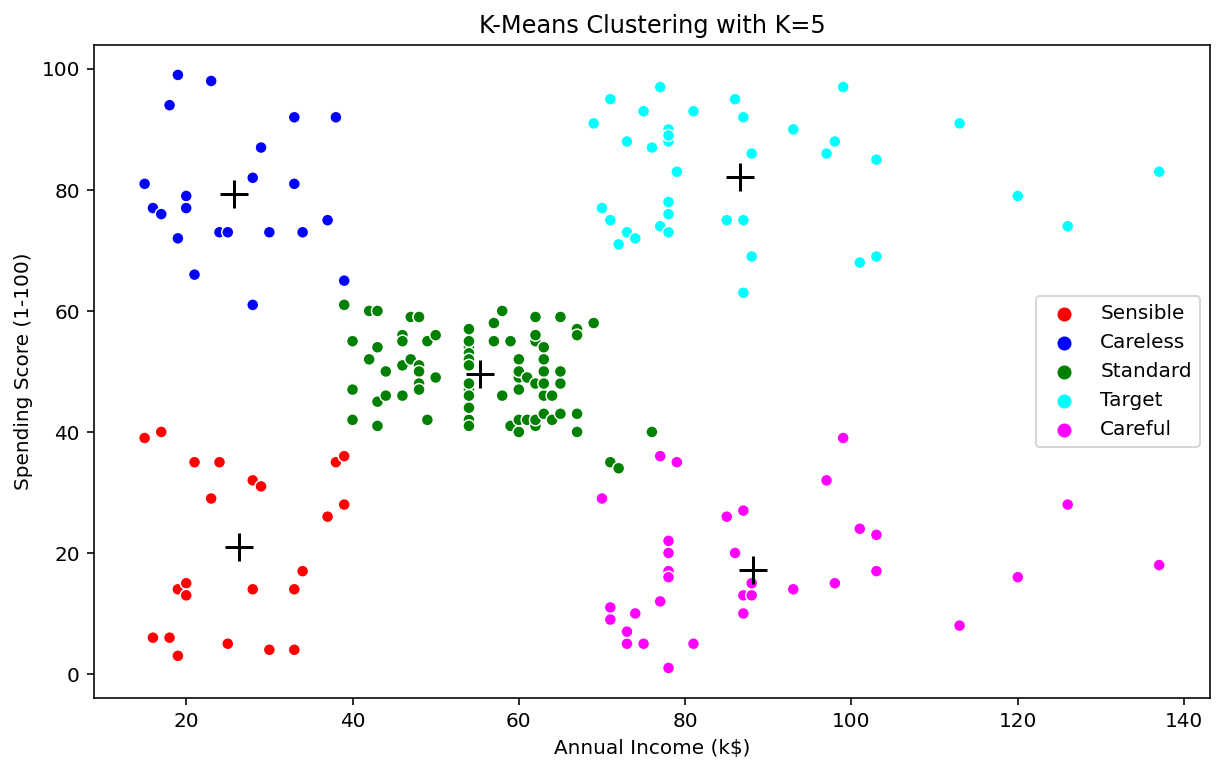

In [13]:
import seaborn as sns

labels = ["Standard", "Careless", "Target", "Sensible", "Careful"]
new_clusters = map(lambda x: labels[x], clusters)

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], hue=new_clusters, 
                palette=["red", "blue", "green", "cyan", "magenta"], ax=ax)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color="black", marker= "+", s=200)
plt.title(f"K-Means Clustering with K={k_best}")
plt.show()

## Clustering complete dataset

In [14]:
X = df.loc[:, :]

In [15]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data):
        assert isinstance(data, pd.DataFrame), "ERROR: Insert pandas DataFrame"
        
        return data[self.columns]

In [16]:
def build_pipeline(model):
    categorical = Pipeline(steps=[
        ("cat_selection", ColumnSelector(columns=qualitative)),
        ("cat_onehot", OneHotEncoder())
    ])
    numerical = Pipeline(steps=[
        ("num_selection", ColumnSelector(columns=quantitative)),
        ("num_onehot", StandardScaler())
    ])
    preprocessor = FeatureUnion(transformer_list=[("categorical", categorical), ("numerical", numerical)])
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    return pipe

In [17]:
wcss = {}

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    model = build_pipeline(kmeans)
    model.fit(X)
    wcss[k] = model[1].inertia_

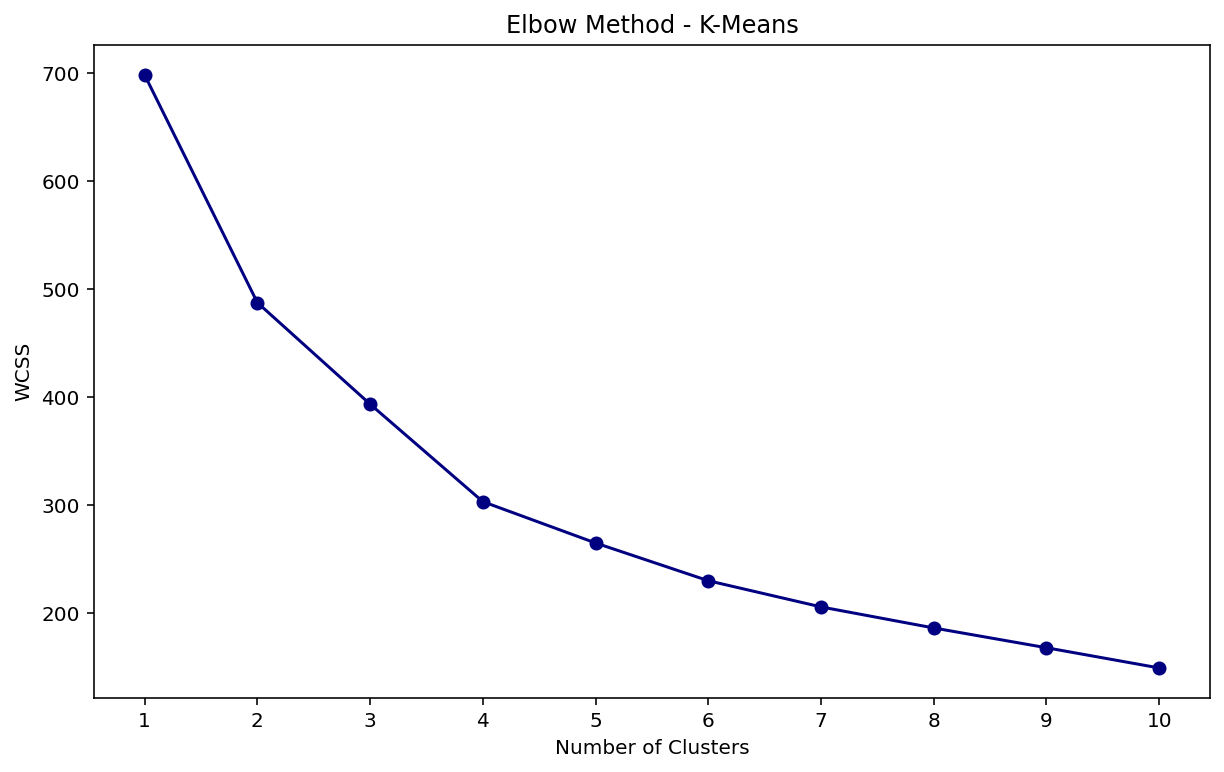

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.set_title("Elbow Method - K-Means")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("WCSS")
ax.xaxis.set_ticks(np.arange(1, 11, 1))
ax.plot(list(wcss.keys()), list(wcss.values()), color="navy")
ax.scatter(list(wcss.keys()), list(wcss.values()), color="navy")
plt.show()

In [19]:
k_best = 4

kmeans = KMeans(n_clusters=k_best, random_state=0, n_jobs=-1)
model = build_pipeline(kmeans)
model.fit(X)
clusters = model.fit_predict(X)

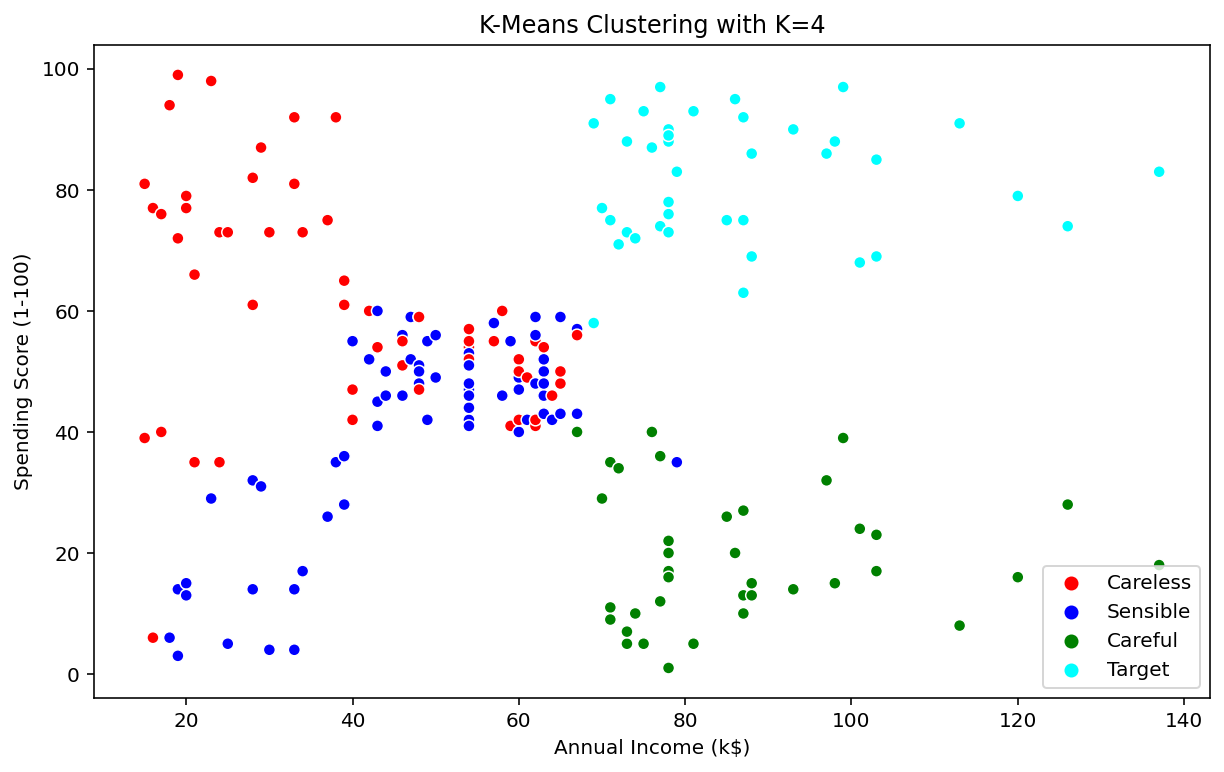

In [20]:
import seaborn as sns

labels = ["Sensible", "Careless", "Careful", "Target"]
new_clusters = map(lambda x: labels[x], clusters)

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.scatterplot(x=X.iloc[:,-2], y=X.iloc[:,-1], hue=new_clusters, 
                palette=["red", "blue", "green", "cyan"], ax=ax)
plt.title(f"K-Means Clustering with K={k_best}")
plt.show()